# Welcome!

👋🏻  I'm Pamela Fox (@pamelafox everywhere)


Today we will..

* Build a regression model using Python and scikit-learn
* Deploy the model as an API using Python on Azure Functions



## [tinyurl.com/regression-slides](https://tinyurl.com/regression-slides)
## [tinyurl.com/regression-repo](https://tinyurl.com/regression-repo)

# Exploring the data

https://insights.stackoverflow.com/survey


## Downloading the data


In [50]:
import urllib.request
import zipfile
import pandas as pd

url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
file = zip_file_object.open('survey_results_public.csv')

survey_data = pd.read_csv(file)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

survey_data.tail(3)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
73265,73266,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby;School or academic work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Technical documentation;Programming Games;Stac...,Udemy;Codecademy;Pluralsight;edX,42,33,"Developer, full-stack;Developer, desktop or en...",20 to 99 employees,I have a great deal of influence,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,NaN,NaN,HTML/CSS;JavaScript;PHP;Python;SQL,C#;HTML/CSS;JavaScript;PHP;Python;SQL,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,Managed Hosting;Microsoft Azure;VMware,Firebase;Linode;Managed Hosting;Microsoft Azur...,ASP.NET;React.js,ASP.NET;ASP.NET Core ;Blazor;Laravel;Next.js;R...,.NET;Pandas;React Native,.NET;Cordova;Ionic;Pandas;React Native;Xamarin,npm,npm;Unreal Engine,Spyder;Visual Studio;Visual Studio Code,Spyder;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Microsoft Lists,Microsoft Lists,Microsoft Teams;Zoom,Microsoft Teams;Zoom,Very unfavorable,Stack Overflow;Stack Exchange,Multiple times per day,Yes,Less than once per month or monthly,"Yes, somewhat",55-64 years old,Man,No,Straight / Heterosexual,Multiracial,None of the above,None of the above,Yes,Independent contributor,42.00000,Disagree,Neither agree nor disagree,Disagree,Agree,Agree,Agree,Neither agree nor disagree,Never,Never,Never,30-60 minutes a day,60-120 minutes a day,Just right,None of these,No,No,No,Appropriate in length,Easy,NaN
73266,73267,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;On the job training,NaN,NaN,50,31,"Developer, front-end;Developer, desktop or ent...",10 to 19 employees,I have a great deal of influence,Start a free trial;Visit developer communities...,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,58500.00000,Yearly,C#;Delphi;VBA,Delphi,Microsoft SQL Server;MongoDB;Oracle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"RAD Studio (Delphi, C++ Builder);Visual Studio","RAD Studio (Delphi, C++ Builder);Visual Studio",Windows,Windows,SVN,Dedicated version control GUI application,NaN,NaN,NaN,NaN,Zoom,Zoom,Indifferent,Stack Overflow,Daily or almost daily,Yes,I have never participated in Q&A on Stack Over...,"No, not at all",55-64 years old,Man,No,Straight / Heterosexual,European,None of the above,None of the above,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN
73267,73268,"I used to be a developer by profession, b

## Cleaning the data

In [51]:
label = "ConvertedCompYearly"

# Drop rows with no data
survey_data = survey_data.dropna(subset = [label])

# Drop rows with extreme outliers
survey_data = survey_data.drop(survey_data[survey_data[label] > 400000].index)

# Check if the numbers look reasonable
survey_data[[label]].describe()

,ConvertedCompYearly
count,36260.00000
mean,80720.59956
std,65852.55164
min,1.00000
25%,33888.75000
50%,63986.00000
75%,110000.00000
max,400000.00000


## Cleaning more columns

In [52]:
numeric_features = ['YearsCode', 'YearsCodePro']

for col_name in numeric_features:
    survey_data[col_name] = pd.to_numeric(survey_data[col_name], errors='coerce')
    survey_data = survey_data.dropna(subset = [col_name])  

survey_data[numeric_features].describe()

,YearsCode,YearsCodePro
count,34685.00000,34685.00000
mean,14.65435,9.84965
std,9.39327,8.06248
min,1.00000,1.00000
25%,8.00000,4.00000
50%,12.00000,7.00000
75%,20.00000,14.00000
max,50.00000,50.00000


## Visualizing the label column

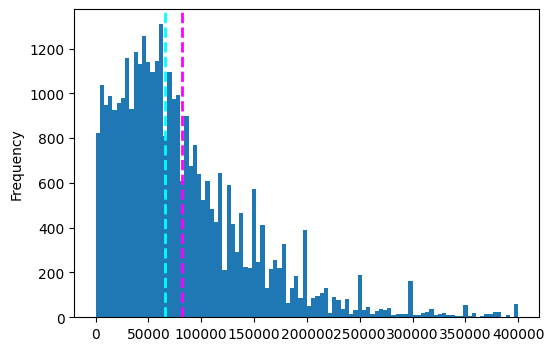

In [53]:
import matplotlib.pyplot as plt

label_data = survey_data[label]
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
ax.hist(label_data, bins=100)
ax.set_ylabel('Frequency')
ax.axvline(label_data.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax.axvline(label_data.median(), color='cyan', linestyle='dashed', linewidth=2)

## Visualizing the feature columns

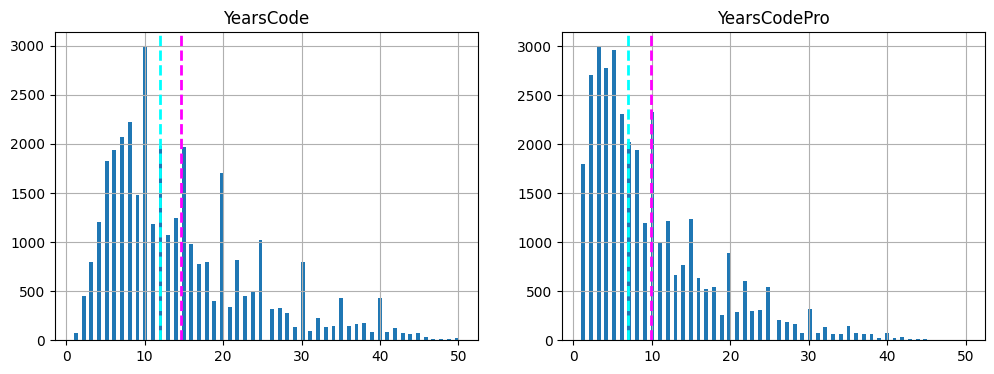

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(12, 4))

for ind, col_name in enumerate(numeric_features):
    feature = survey_data[col_name]
    axis = axes[ind]
    feature.hist(bins=100, ax = axis)
    axis.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    axis.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    axis.set_title(col_name)

## Measuring correlations

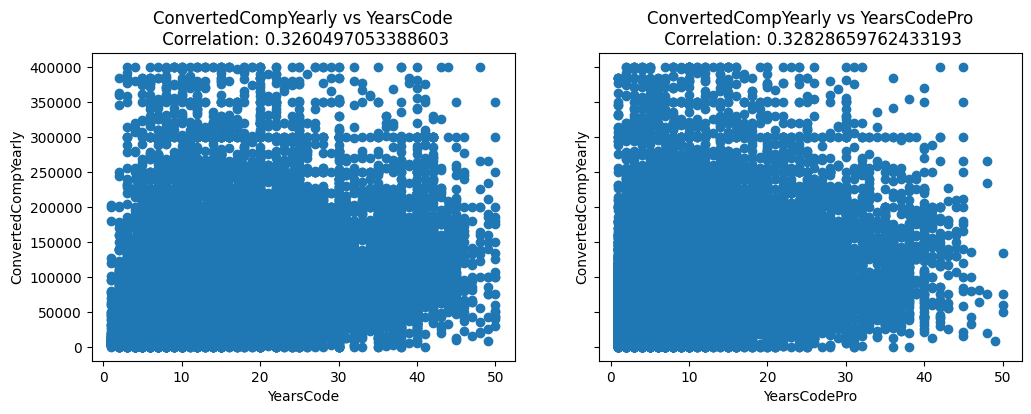

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(12, 4), sharey=True)

for ind, feature in enumerate(numeric_features):
    label_data = survey_data[label]
    feature_data = survey_data[feature]
    correlation = feature_data.corr(label_data)
    axis = axes[ind]
    axis.scatter(x=feature_data, y=label_data)
    axis.set_xlabel(feature)
    axis.set_ylabel(label)
    axis.set_title(f'{label} vs {feature}\n Correlation: {correlation}')

# Building a model

## Separating test and train data

In [56]:
# Separate features and labels
X = survey_data[numeric_features].values
y = survey_data[label].values
print('Features:', X[:5], '\nLabels:', y[:5], sep='\n')

Features:
[[14.  5.]
 [20. 17.]
 [ 6.  6.]
 [ 5.  2.]
 [12. 10.]]

Labels:
[ 40205. 215232.  49056.  60307. 194400.]


In [57]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print(f'Training Set: {X_train.shape[0]} rows\n    Test Set: {X_test.shape[0]} rows')

Training Set: 26013 rows
    Test Set: 8672 rows


## Training the model

In [58]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)
print(model.coef_)
print(model.intercept_)

# y = mx + b
# yearsCode, yearsCodePro
# y = yearsCode(x) + b1 + yearsCodeProp(x) + b2
# y = 1203x + 1363x + 51207

[1203.43950058 1363.41091693]
51207.87075534061


## Evaluating model on test data

In [59]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)

print('Predicted labels: ', np.round(predictions)[:8])
print('Actual labels   : ', y_test[:8])

Predicted labels:  [83777. 61315. 72626. 60112. 78643. 65969. 67332. 65969.]
Actual labels   :  [47350. 51763. 13212.    50. 38392.  3864. 14952. 58654.]


## Visualizing the predictions

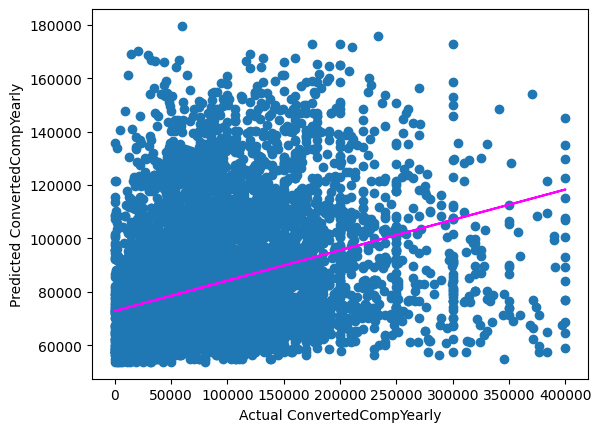

In [60]:
plt.scatter(y_test, predictions)
plt.xlabel(f'Actual {label}')
plt.ylabel(f'Predicted {label}')

# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='magenta')

## Calculating evaluation metrics

In [62]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print(" MSE:", mse)

rmse = mean_squared_error(y_test, predictions, squared=False)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("  R2:", r2)

 MSE: 3869649622.530541
RMSE: 62206.50787924477
  R2: 0.11892933995226618


# Experimenting with more models

* **Linear algorithms**: Besides the one already used (an Ordinary Least Squares algorithm), there are other variants such as Lasso and Ridge.
* **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction.
* **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## Generalizing the evaluation process

                Model        RMSE      R2
0  LinearRegression() 62206.50790 0.11890


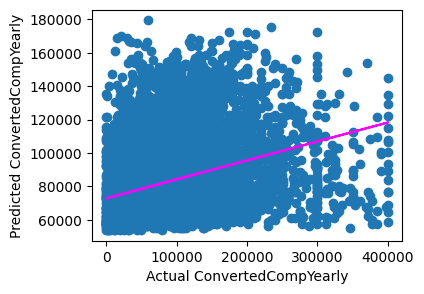

In [63]:
eval_results = pd.DataFrame(columns=['Model', 'RMSE', 'R2'])

def evaluate_model():
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    r2 = r2_score(y_test, predictions)
    eval_results.loc[len(eval_results.index)] = [str(model), round(rmse, 4), round(r2, 4)]
    print(eval_results)
    # Plot predicted vs actual
    plt.figure(figsize=(4, 3)) 
    plt.scatter(y_test, predictions)
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    # Overlay the regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    

evaluate_model()  

## Lasso (linear regression)

[Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso) works well when only a few features predict the label.

                Model        RMSE      R2
0  LinearRegression() 62206.50790 0.11890
1             Lasso() 62206.52210 0.11890


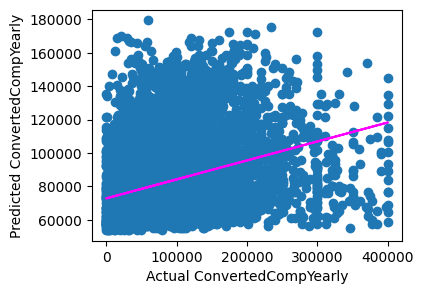

In [64]:
from sklearn.linear_model import Lasso

model = Lasso().fit(X_train, y_train)

evaluate_model()

## Decision tree

[Decision trees](https://scikit-learn.org/stable/modules/tree.html) can be used for both regression and classification problems.

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text, plot_tree

model = DecisionTreeRegressor().fit(X_train, y_train)

print(export_text(model))

|--- feature_1 <= 5.50
|   |--- feature_1 <= 3.50
|   |   |--- feature_0 <= 5.50
|   |   |   |--- feature_1 <= 2.50
|   |   |   |   |--- feature_1 <= 1.50
|   |   |   |   |   |--- feature_0 <= 4.50
|   |   |   |   |   |   |--- feature_0 <= 2.50
|   |   |   |   |   |   |   |--- feature_0 <= 1.50
|   |   |   |   |   |   |   |   |--- value: [37842.27]
|   |   |   |   |   |   |   |--- feature_0 >  1.50
|   |   |   |   |   |   |   |   |--- value: [38147.25]
|   |   |   |   |   |   |--- feature_0 >  2.50
|   |   |   |   |   |   |   |--- feature_0 <= 3.50
|   |   |   |   |   |   |   |   |--- value: [34579.25]
|   |   |   |   |   |   |   |--- feature_0 >  3.50
|   |   |   |   |   |   |   |   |--- value: [32674.00]
|   |   |   |   |   |--- feature_0 >  4.50
|   |   |   |   |   |   |--- value: [40668.49]
|   |   |   |   |--- feature_1 >  1.50
|   |   |   |   |   |--- feature_0 <= 3.50
|   |   |   |   |   |   |--- feature_0 <= 2.50
|   |   |   |   |   |   |   |--- feature_0 <= 1.50
|   |   |   | 

## Decision tree (visualization)

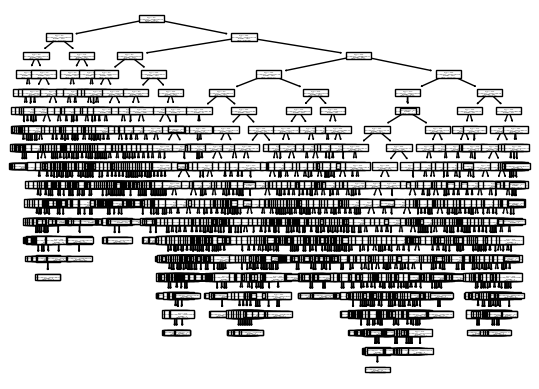

In [66]:
plot_tree(model)
plt.show()

## Decision tree (evaluation)

                     Model        RMSE      R2
0       LinearRegression() 62206.50790 0.11890
1                  Lasso() 62206.52210 0.11890
2  DecisionTreeRegressor() 63142.79470 0.09220


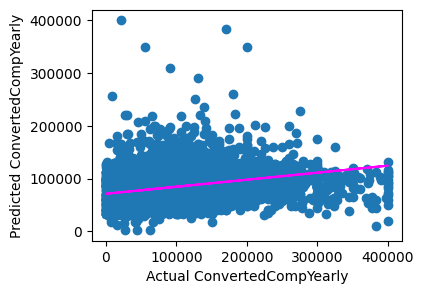

In [67]:
evaluate_model()

## Random forest (ensemble)

[Random forest](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees) applies an averaging function to multiple Decision Tree models for a better overall model.


                     Model        RMSE      R2
0       LinearRegression() 62206.50790 0.11890
1                  Lasso() 62206.52210 0.11890
2  DecisionTreeRegressor() 63142.79470 0.09220
3  RandomForestRegressor() 62625.00760 0.10700


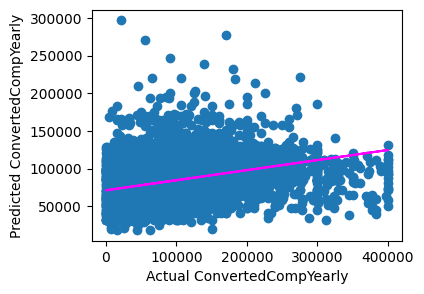

In [68]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor().fit(X_train, y_train)

evaluate_model()

## Gradient tree boosting regressor

[Gradient tree boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) iterates on tree models to find the best one.

                         Model        RMSE      R2
0           LinearRegression() 62206.50790 0.11890
1                      Lasso() 62206.52210 0.11890
2      DecisionTreeRegressor() 63142.79470 0.09220
3      RandomForestRegressor() 62625.00760 0.10700
4  GradientBoostingRegressor() 61513.26320 0.13850


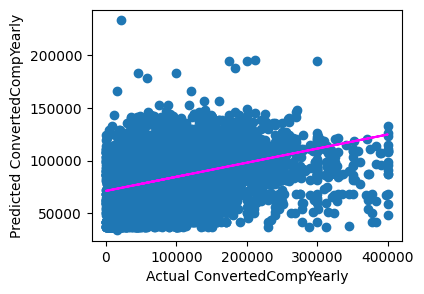

In [69]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor().fit(X_train, y_train)

evaluate_model()

# Improving the model

* Tuning hyperparameters
* Incorporating categorical features

https://learn.microsoft.com/en-us/training/modules/train-evaluate-regression-models/6-improve-models
    

## Tuning hyperparameters

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
}

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model = gridsearch.best_estimator_
print(model, "\n")

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 50} 

GradientBoostingRegressor(n_estimators=50) 



## Evaluating tuned model

                                        Model        RMSE      R2
0                          LinearRegression() 62206.50790 0.11890
1                                     Lasso() 62206.52210 0.11890
2                     DecisionTreeRegressor() 63142.79470 0.09220
3                     RandomForestRegressor() 62625.00760 0.10700
4                 GradientBoostingRegressor() 61513.26320 0.13850
5  GradientBoostingRegressor(n_estimators=50) 61461.72110 0.13990


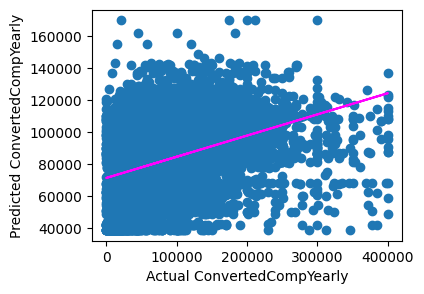

In [71]:
evaluate_model()

## Preparing categorical features

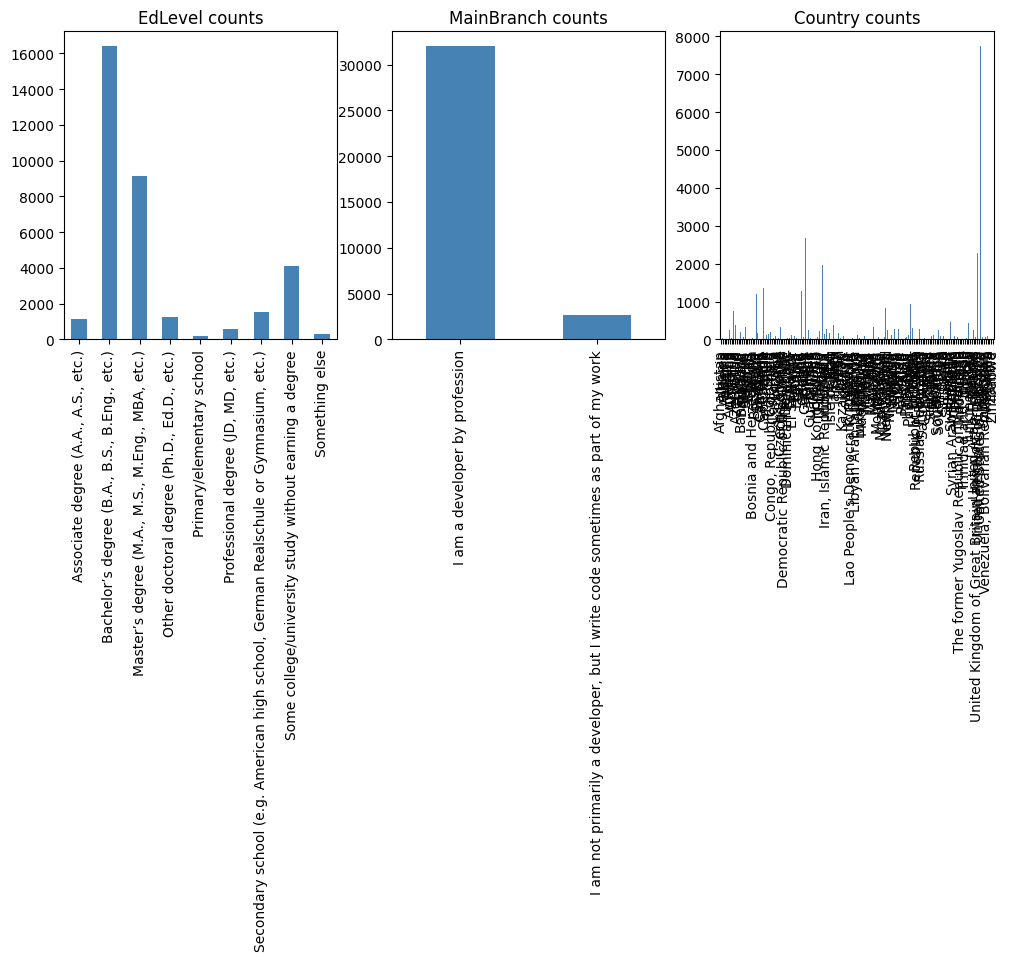

In [72]:
categorical_features = ['EdLevel', 'MainBranch', 'Country']

for col_name in categorical_features:
    survey_data = survey_data.dropna(subset = [col_name])  
    
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(12, 4))

for ind, col_name in enumerate(categorical_features):
    counts = survey_data[col_name].value_counts().sort_index()
    axis = axes[ind]
    counts.plot.bar(ax=axis, color='steelblue')
    axis.set_title(col_name + ' counts')

## Creating a pipeline with categorical features

In [73]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Separate features and labels
X = survey_data[numeric_features + categorical_features].values
y = survey_data[label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Define preprocessing for numeric columns (scale them)
numeric_features_indices = [0, 1]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features_indices = [2, 3, 4]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_indices),
        ('cat', categorical_transformer, categorical_features_indices)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])
model = pipeline.fit(X_train, (y_train))

## Evaluating model with categorical features

                                               Model        RMSE      R2
0                                 LinearRegression() 62206.50790 0.11890
1                                            Lasso() 62206.52210 0.11890
2                            DecisionTreeRegressor() 63142.79470 0.09220
3                            RandomForestRegressor() 62625.00760 0.10700
4                        GradientBoostingRegressor() 61513.26320 0.13850
5         GradientBoostingRegressor(n_estimators=50) 61461.72110 0.13990
6  Pipeline(steps=[('preprocessor',\n            ... 48709.53340 0.45590


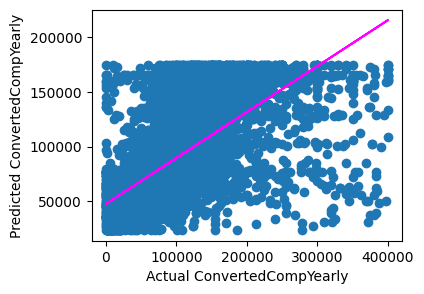

In [74]:
evaluate_model()

## Storing the model

In [75]:
import joblib

# Save the model as a pickle file
filename = '../function/model_predict/model.pkl'
joblib.dump(model, filename)

['../function/model_predict/model.pkl']

## Using the stored model

In [77]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[25, 15, 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)','I am a developer by profession', 'United States of America']])
print(f'New sample: {X_new[0]}')

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print(f'Prediction: {np.round(result[0])}')

New sample: ['25' '15' 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)'
 'I am a developer by profession' 'United States of America']
Prediction: 174335.0


# Turning the model into an HTTP API

## HTTP API architecture


![Diagram of client making HTTP GET call to Azure function](function_api.png)

## Azure function code

```python
import os

import azure.functions
import fastapi
import joblib
import nest_asyncio
import numpy

app = fastapi.FastAPI()
nest_asyncio.apply()
model = joblib.load(f"{os.path.dirname(os.path.realpath(__file__))}/model.pkl")

@app.get("/model_predict")
async def predict(years_coding: int, years_coding_pro: int, ed_level: str, dev_status: str, country: str):
    X_new = numpy.array([[years_coding, years_coding_pro, ed_level, dev_status, country]])
    result = model.predict(X_new)
    return {"salary": round(result[0], 2)}

async def main(
    req: azure.functions.HttpRequest, context: azure.functions.Context
) -> azure.functions.HttpResponse:
    return azure.functions.AsgiMiddleware(app).handle(req, context)
```

## Deploying the function

Many ways to deploy: [Azure Tools VS Code extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode.vscode-node-azure-pack), [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/?WT.mc_id=python-79071-pamelafox), [Azure Dev CLI](https://learn.microsoft.com/en-us/azure/developer/azure-developer-cli/overview?WT.mc_id=python-79071-pamelafox) (In public preview).

Using the Azure Dev CLI:

```shell
% azd up
```


```shell
Provisioning Azure resources can take some time.
You can view detailed progress in the Azure Portal:
https://portal.azure.com/#blade/HubsExtension/DeploymentDetailsBlade/...

Created Resource group: salary-model1-rg
Created App Service plan: salary-model1-dtlpju3kmywzs-plan
Created Log Analytics workspace: salary-model1-dtlpju3kmywzs-logworkspace
Created Application Insights: salary-model1-dtlpju3kmywzs-appinsights
Created Storage account: salarymodel1dtlpjstorage
Created Web App: salary-model1-dtlpju3kmywzs-function-app

Azure resource provisioning completed successfully

Deployed service api
 - Endpoint: https://salary-model1-dtlpju3kmywzs-function-app.azurewebsites.net/

View the resources created under the resource group salary-model1-rg in Azure Portal:
https://portal.azure.com/#@/resource/subscriptions/32ea8a26-5b40-4838-b6cb-be5c89a57c16/resourceGroups/salary-model1-rg/overview
```

## Calling the HTTP API

Example API call:
    
[/model_predict?years_coding=25&years_coding_pro=15&ed_level=Master%E2%80%99s%20degree%20%28M.A.%2C%20M.S.%2C%20M.Eng.%2C%20MBA%2C%20etc.%29&dev_status=I%20am%20a%20developer%20by%20profession&
country=United%20States%20of%20America](https://salary-model1-dtlpju3kmywzs-function-app.azurewebsites.net/model_predict?years_coding=25&years_coding_pro=15&ed_level=Master%E2%80%99s%20degree%20%28M.A.%2C%20M.S.%2C%20M.Eng.%2C%20MBA%2C%20etc.%29&dev_status=I%20am%20a%20developer%20by%20profession&country=United%20States%20of%20America)


Results:

```
{"salary":171993.74}
```

## Auto-generated documentation

FastAPI auto-generates documentation based on the function signature.
    
* [/docs](https://salary-model1-dtlpju3kmywzs-function-app.azurewebsites.net/docs)
* [/redoc](https://salary-model1-dtlpju3kmywzs-function-app.azurewebsites.net/redoc)

![Screenshot of auto-generated docs](autodocs.png)

## Handling categorical features better

```python
# import ...
from . import categories

app = fastapi.FastAPI()
nest_asyncio.apply()
model = joblib.load(f"{os.path.dirname(os.path.realpath(__file__))}/model.pkl")

@app.get("/model_predict")
async def model_predict(
    years_coding: int,
    years_coding_pro: int,
    ed_level: categories.EdLevel,
    dev_status: categories.MainBranch,
    country: categories.Country,
):
    X_new = numpy.array([[years_coding, years_coding_pro, ed_level.value, dev_status.value, country.value]])
    result = model.predict(X_new)
    return {"salary": round(result[0], 2)}

async def main(
    req: azure.functions.HttpRequest, context: azure.functions.Context
) -> azure.functions.HttpResponse:
    return azure.functions.AsgiMiddleware(app).handle(req, context)
```


## The category enums file

```python
from enum import Enum

class EdLevel(str, Enum):
    EDLEVEL_0 = "Associate degree (A.A., A.S., etc.)"
    EDLEVEL_1 = "Bachelor’s degree (B.A., B.S., B.Eng., etc.)"
    EDLEVEL_2 = "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)"
    EDLEVEL_3 = "Other doctoral degree (Ph.D., Ed.D., etc.)"
    EDLEVEL_4 = "Primary/elementary school"
    EDLEVEL_5 = "Professional degree (JD, MD, etc.)"
    EDLEVEL_6 = "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)"
    EDLEVEL_7 = "Some college/university study without earning a degree"
    EDLEVEL_8 = "Something else"

class MainBranch(str, Enum):
    MAINBRANCH_0 = "I am a developer by profession"
    MAINBRANCH_1 = "I am not primarily a developer, but I write code sometimes as part of my work"

class Country(str, Enum):
    COUNTRY_0 = "Afghanistan"
    COUNTRY_1 = "Albania"
    COUNTRY_2 = "Algeria"
    ...
```

## Generating the category enums

In [ ]:
enums_lines = []

for feature in categorical_features:
    enums_lines.append(f'class {feature}(str, Enum):')
    for ind, value in enumerate(sorted(survey_data[feature].unique())):
        enum_name = f'{feature.upper()}_{ind}'
        enums_lines.append(f'    {enum_name} = "{value}"')
    enums_lines.append('\n')

enums_module = 'from enum import Enum\n\n'  + '\n'.join(enums_lines)
f = open("../function/model_predict/categories.py", "w")
f.write(enums_module)
f.close()

## Re-deploying the function

Since the only change is code, I can just run:
    
```shell
% azd deploy
```

```shell
Deploying service api...
Deployed service api
 - Endpoint: https://salary-model1-dtlpju3kmywzs-function-app.azurewebsites.net/
```

## Auto-generated documentation for category enums

The categories in the [docs](https://salary-model2-sibqf23ha7ib2-function-app.azurewebsites.net/docs) are now dropdowns with all available options.

![Screenshot of auto-generated docs](autodocs_withcats.png)

# Next steps

* If you haven't yet, go through [the tutorial on regression models](https://learn.microsoft.com/training/modules/train-evaluate-regression-models/?WT.mc_id=python-79071-pamelafox)
* Check out [the code for this example](https://github.com/pamelafox/regression-model-azure-demo) and try deploying yourself 
* Learn more about creating Azure functions in Python with the [Azure CLI](https://learn.microsoft.com/azure/azure-functions/create-first-function-cli-python?tabs=azure-cli%2Cbash&pivots=python-mode-configuration&WT.mc_id=python-79071-pamelafox) or [VS Code](https://learn.microsoft.com/azure/azure-functions/create-first-function-vs-code-python?pivots=python-mode-configuration&WT.mc_id=python-79071-pamelafox)
* Learn about more ways to [host Python on Azure](https://learn.microsoft.com/azure/developer/python/quickstarts-app-hosting?WT.mc_id=python-79071-pamelafox)
* Learn about the [Azure ML SDKs](https://learn.microsoft.com/python/api/overview/azure/ml/?view=azure-ml-py&WT.mc_id=python-79071-pamelafox)
* Attend the next talk in this series!
